<a href="https://colab.research.google.com/github/yasyamauchi/education/blob/main/m5Stack_IMU2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# プロジェクトⅤ(旧生体医工学実験Ⅱ)用(2025) m5stackのIMUデータ処理

2025/02/24　山内  
  
  2023年のものを以下のように改造  
  * サンプリング周波数は40Hzに上げる
  * X(前後方向)とY(左右方向)の回転角を扱う
  * スペクトログラムとフーリエ変換を行う

### Scipyの参考：  https://atatat.hatenablog.com/entry/data_proc_python4

In [26]:
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

## ローパスフィルタ

In [27]:
def lowpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2   #ナイキスト周波数
    wp = fp / fn  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y

## 次でデータファイル名を指定する

In [28]:
m5stack = np.loadtxt('C.csv',delimiter=',',skiprows=1)

## フィルタ処理とグラフ描画

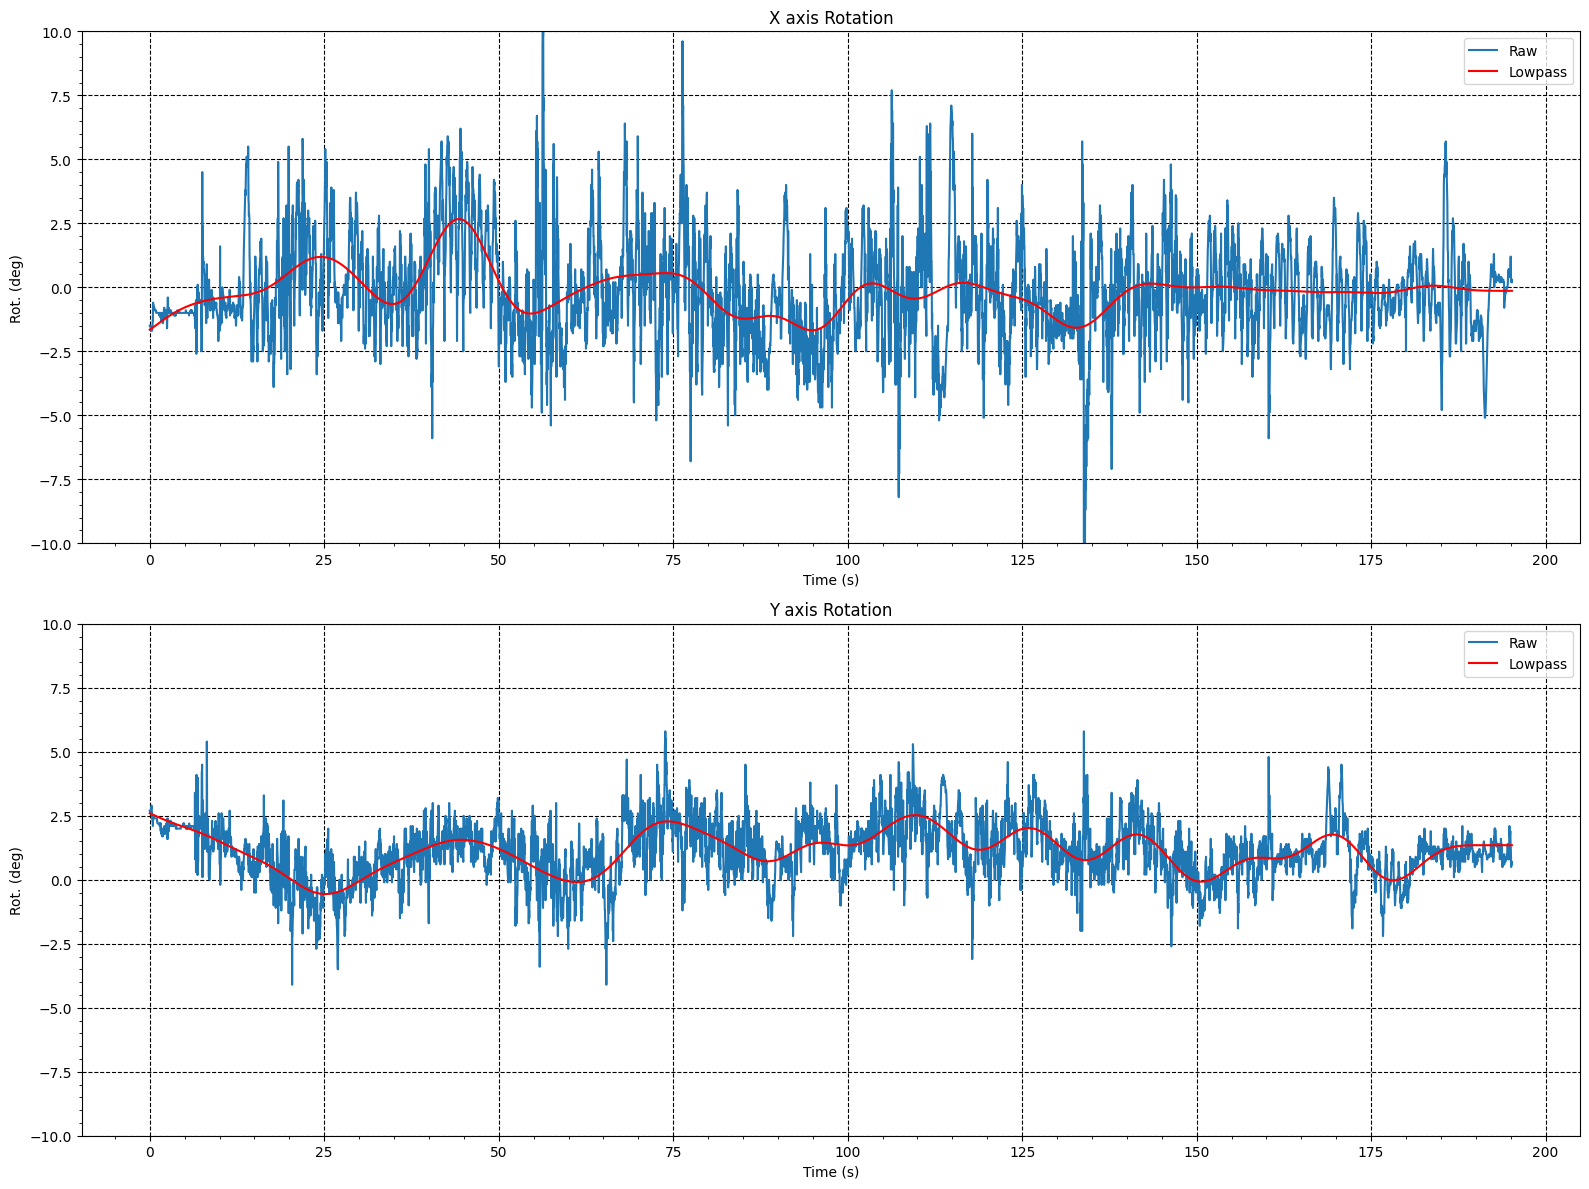

In [29]:
samplerate = 40 # サンプリング周波数は10Hz
fp = 0.08 # 通過域端周波数[Hz]
fs = 0.2 # 阻止域端周波数[Hz]
gpass = 3 # 通過域端最大損失[dB]
gstop = 40 # 阻止域端最小損失[dB]

x = np.arange(0, m5stack.shape[0]) / samplerate
AccX = m5stack[:,4]
AccY = m5stack[:,5]
AccZ = m5stack[:,6]
RotX = m5stack[:,7]
RotY = m5stack[:,8]

# ローパスをする関数を実行
RotX_lofilt = lowpass(RotX, samplerate, fp, fs, gpass, gstop)
RotY_lofilt = lowpass(RotY, samplerate, fp, fs, gpass, gstop)

# グラフ描画
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(x,RotX)
ax1.plot(x,RotX_lofilt,'r')
ax1.legend(['Raw','Lowpass'])
ax1.set_title('X axis Rotation')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Rot. (deg)')
ax1.set_ylim(-10,10)
ax1.minorticks_on()
ax1.grid(color="black", linestyle="--")

ax2.plot(x,RotY)
ax2.plot(x,RotY_lofilt,'r')
ax2.legend(['Raw','Lowpass'])
ax2.set_title('Y axis Rotation')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Rot. (deg)')
ax2.set_ylim(-10,10)
ax2.minorticks_on()
ax2.grid(color="black", linestyle="--")

fig.tight_layout()              #レイアウトの設定
#plt.savefig('up.png') # PNGファイルとしてグラフを保存
plt.show()

*上がRotX(前後の傾き)，下がRotY(左右の傾き)*

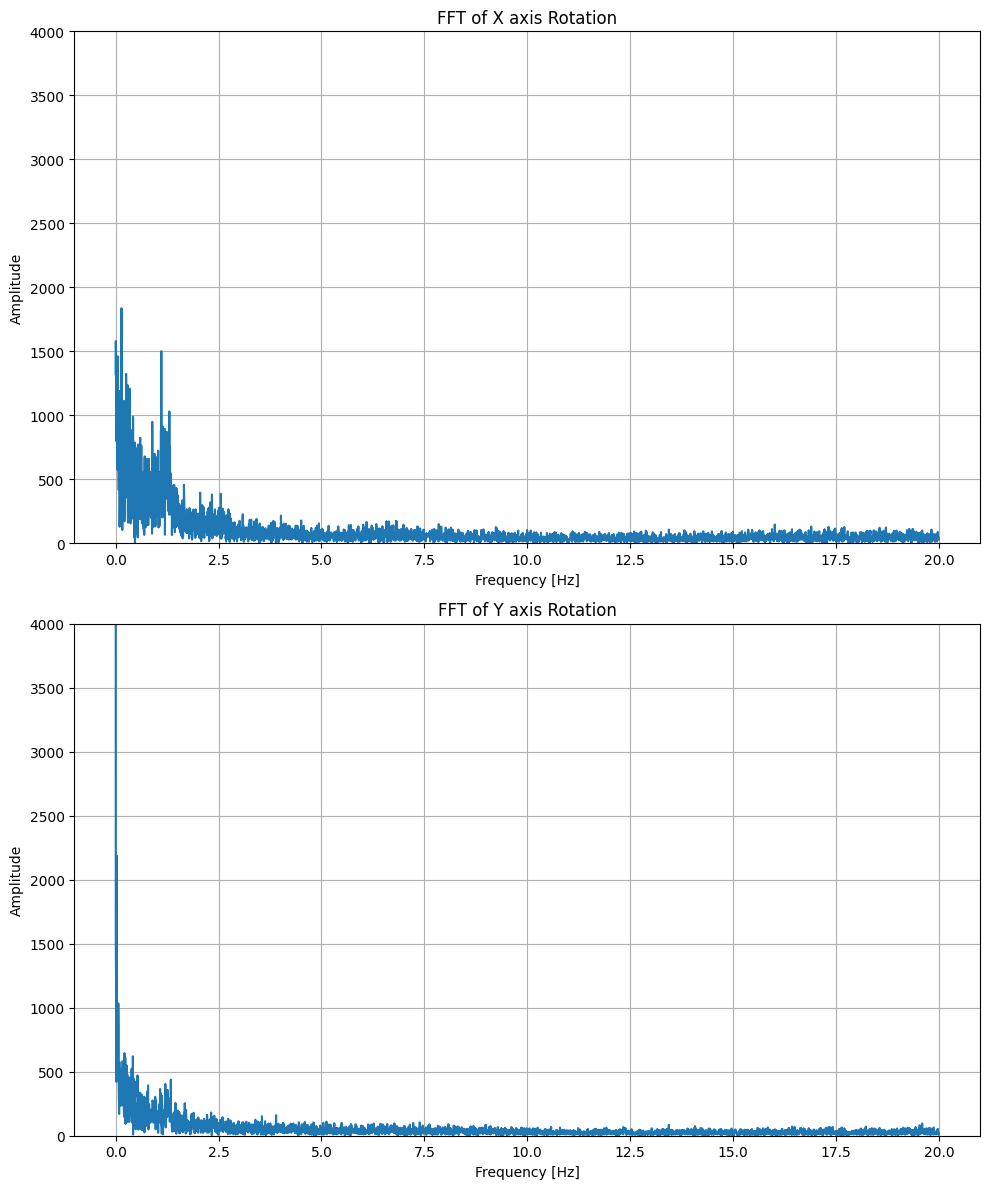

In [30]:
from scipy.fft import fft, fftfreq

N = len(RotX) # Length of the AccY data
yf1 = fft(RotX) # Perform the Fourier Transform on AccY
xf1 = fftfreq(N, 1 / samplerate) # Generate frequency axis for the transformed data
yf2 = fft(RotY) # Perform the Fourier Transform on AccY
xf2 = fftfreq(N, 1 / samplerate) # Generate frequency axis for the transformed data

# Plot the single-sided amplitude spectrum
fig = plt.figure(figsize=(10, 12))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(xf1[0:N//2], np.abs(yf1[0:N//2])) # Plot the positive frequencies
ax1.set_title('FFT of X axis Rotation')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Amplitude')
ax1.set_ylim(0,4000)
ax1.grid()

ax2.plot(xf2[0:N//2], np.abs(yf2[0:N//2])) # Plot the positive frequencies
ax2.set_title('FFT of Y axis Rotation')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Amplitude')
ax2.set_ylim(0,4000)
ax2.grid()

fig.tight_layout()              #レイアウトの設定

plt.show()

Text(0.5, 0, 'Time [sec]')

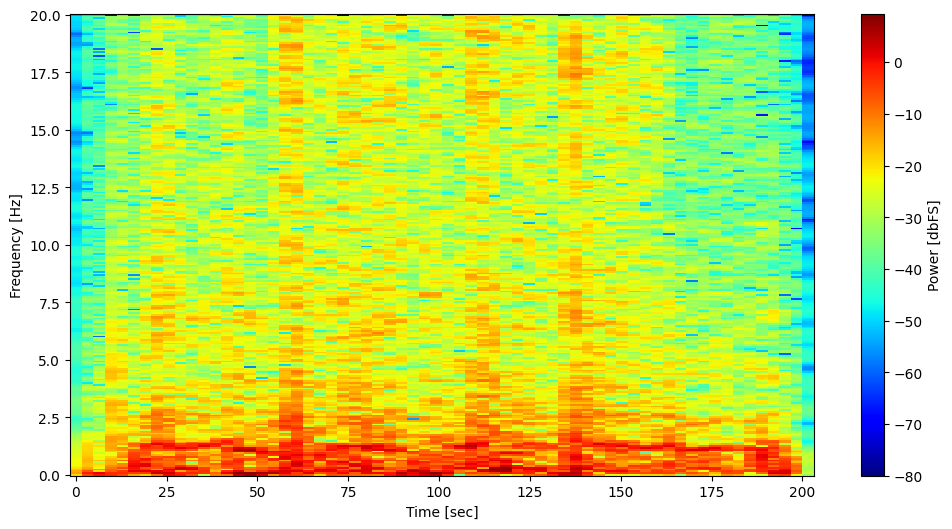

In [31]:
# 参考：https://nettyukobo.com/python_scipy_signal_spectrogram/

# 窓関数作成
win = signal.windows.hann(512)  # 窓関数

# スぺクトログラム作成
SFT = signal.ShortTimeFFT(win, hop=128, fs=samplerate, fft_mode='onesided2X', scale_to='magnitude')
Sxx = SFT.spectrogram(RotX)
Sxx_dB = 10 * np.log10(np.fmax(Sxx, 1e-8))

# 時間軸と周波数軸の作成
N_t = np.arange(Sxx.shape[1])
t = SFT.delta_t * N_t
f = SFT.f

# グラフ作成
fig = plt.figure(figsize=(12,6))
plt.pcolormesh(t, f, Sxx_dB, cmap="jet")
plt.colorbar(label="Power [dbFS]")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
# plt.savefig("spectrogram1.png")

NameError: name 'spectrogram1' is not defined

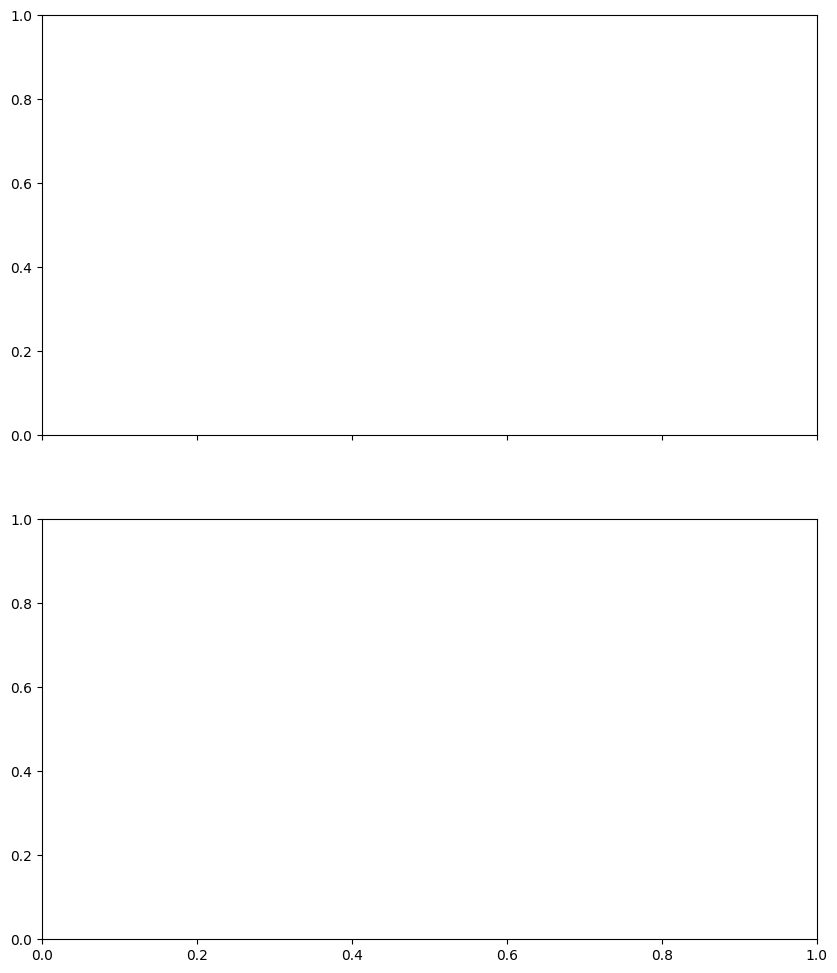

In [32]:
# 参考：https://phst.hateblo.jp/entry/2019/09/20/144954
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 12))

mesh = axes[0].pcolormesh(spectrogram1, vmin=0, vmax=2.5)
mesh = axes[1].pcolormesh(spectrogram2, vmin=0, vmax=2.5)
fig.colorbar(mesh, ax=axes)
axes[0].set_title('Spectrogram of X axis Rotation')
axes[0].set_ylabel('Frequency [Hz]')
axes[1].set_title('Spectrogram of Y axis Rotation')
axes[1].set_xlabel('Time [sec]')
axes[1].set_ylabel('Frequency [Hz]')

plt.show()